# End-to-end Traffic Sign Recognition (GTSRB)

## 1. Project Overview
This notebook builds a complete Deep Learning pipeline to classify German Traffic Signs into 43 categories.
**Key Features:**
* **Architecture:** MobileNetV2 (Transfer Learning)
* **Performance:** ~93-98% Test Accuracy
* **Deployment:** Interactive Gradio Web App

## 2. Setup & Imports

In [ ]:
import os
import logging
import zipfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import shutil
import random
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Dict, Optional, List

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Setting up Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', force=True)
logger = logging.getLogger(__name__)

### Setting up

In [ ]:
@dataclass
class Config:
    """Central configuration for reproducibility and easy tuning."""
    PROJECT_NAME: str = "GTSRB_TRAFFIC_SIGN"

    # Paths (Colab & Drive)
    DATA_ROOT: Path = Path("/content/GTSRB_local")
    TRAIN_DIR: Path = Path("/content/GTSRB_local/Train")
    TEST_DIR: Path = Path("/content/GTSRB_local/Test")
    ZIP_PATH: Path = Path("/content/drive/MyDrive/GTSRB/Traffic Project/Train.zip")
    TEST_ZIP_PATH: Path = Path("/content/drive/MyDrive/GTSRB/Traffic Project/Test.zip")
    TEST_CSV_PATH: Path = Path("/content/GTSRB_local/Test.csv")
    SIGN_NAMES_URL: str = "https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv"


    IMG_SIZE: Tuple[int, int] = (160, 160)
    NUM_CHANNELS: int = 3
    NUM_CLASSES: int = 43
    BATCH_SIZE: int = 32
    LEARNING_RATE: float = 1e-4
    EPOCHS: int = 30
    SEED: int = 42

    # Model Regularization
    DROPOUT_RATE: float = 0.2
    FINE_TUNE_AT: int = 50

    def __post_init__(self):
        self.INPUT_SHAPE = (*self.IMG_SIZE, self.NUM_CHANNELS)
        np.random.seed(self.SEED)
        tf.random.set_seed(self.SEED)

## 3. Data Pipeline
Handles downloading, extracting, and fixing folder structures for the GTSRB dataset.

In [ ]:
class GTSRBDataManager:
    """Handles data downloading, extraction, and dataset creation."""

    def __init__(self, config: Config):
        self.cfg = config
        self.class_names = None

    def setup_data(self):
        """Checks for data and downloads/extracts/organizes if necessary."""
        # Training Data
        if not self.cfg.TRAIN_DIR.exists():
            if self.cfg.ZIP_PATH.exists():
                logger.info(f"Unzipping Train data...")
                with zipfile.ZipFile(self.cfg.ZIP_PATH, 'r') as zip_ref:
                    zip_ref.extractall(self.cfg.DATA_ROOT)
                logger.info("Unzipping Train complete.")
            else:
                logger.warning(f"Train Zip not found at {self.cfg.ZIP_PATH}")

        # 2. Test Data (fixes structure as well)
        test_has_images = self.cfg.TEST_DIR.exists() and len(list(self.cfg.TEST_DIR.glob("*.png"))) > 0

        if not test_has_images:
            if self.cfg.TEST_ZIP_PATH.exists():
                logger.info(f"Unzipping Test data...")
                with zipfile.ZipFile(self.cfg.TEST_ZIP_PATH, 'r') as zip_ref:
                    zip_ref.extractall(self.cfg.DATA_ROOT)

                loose_images = list(self.cfg.DATA_ROOT.glob("*.png"))
                if loose_images:
                    logger.info(f"Found {len(loose_images)} loose images. Moving to {self.cfg.TEST_DIR}...")
                    self.cfg.TEST_DIR.mkdir(exist_ok=True)
                    for img in loose_images:
                        shutil.move(str(img), str(self.cfg.TEST_DIR / img.name))
                    logger.info("Test data organized successfully.")
            else:
                logger.warning(f"Test Zip not found at {self.cfg.TEST_ZIP_PATH}")

        # Downloading labels
        label_file = self.cfg.DATA_ROOT / "signnames.csv"
        if not label_file.exists():
            try:
                response = requests.get(self.cfg.SIGN_NAMES_URL)
                response.raise_for_status()
                with open(label_file, 'w') as f:
                    f.write(response.text)
            except Exception as e:
                logger.error(f"Failed to download labels : {e}")

        # Copying Test CSV
        drive_csv = self.cfg.TEST_ZIP_PATH.parent / "Test.csv"
        local_csv = self.cfg.DATA_ROOT / "Test.csv"
        if drive_csv.exists() and not local_csv.exists():
             shutil.copy(drive_csv, local_csv)

    def load_signnames_csv(self):
        label_path = self.cfg.DATA_ROOT / "signnames.csv"
        if not label_path.exists(): return {}
        try:
            df = pd.read_csv(label_path)
            return dict(zip(df["ClassId"], df["SignName"]))
        except Exception: return {}

    def get_datasets(self) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
        """Creates optimized training and validation datasets."""
        if not self.cfg.TRAIN_DIR.exists():
            raise FileNotFoundError(f"Training directory not found: {self.cfg.TRAIN_DIR}")

        logger.info("Creating datasets from directory...")

        def preprocess(image, label):
            image = tf.cast(image, tf.float32)
            image = applications.mobilenet_v2.preprocess_input(image)
            return image, label

        train_ds = tf.keras.utils.image_dataset_from_directory(
            self.cfg.TRAIN_DIR, validation_split=0.2, subset="training",
            seed=self.cfg.SEED, image_size=self.cfg.IMG_SIZE,
            batch_size=self.cfg.BATCH_SIZE, label_mode='categorical'
        )

        self.class_names = train_ds.class_names
        logger.info(f"Captured {len(self.class_names)} classes.")

        val_ds = tf.keras.utils.image_dataset_from_directory(
            self.cfg.TRAIN_DIR, validation_split=0.2, subset="validation",
            seed=self.cfg.SEED, image_size=self.cfg.IMG_SIZE,
            batch_size=self.cfg.BATCH_SIZE, label_mode='categorical'
        )

        autotune = tf.data.AUTOTUNE
        train_ds = train_ds.map(preprocess, num_parallel_calls=autotune).shuffle(200).prefetch(autotune)
        val_ds = val_ds.map(preprocess, num_parallel_calls=autotune).prefetch(autotune)
        return train_ds, val_ds

    def get_test_dataset(self):
        """Loads the test dataset robustly, skipping missing files."""
        if not self.cfg.TEST_CSV_PATH.exists(): return None
        if self.class_names is None:
            logger.error("Run get_datasets() first to learn class order.")
            return None

        logger.info(f"Loading test data from {self.cfg.TEST_CSV_PATH}...")
        df = pd.read_csv(self.cfg.TEST_CSV_PATH)

        folder_to_index = {name: i for i, name in enumerate(self.class_names)}
        def remap_label(real_id):
            return folder_to_index.get(str(real_id), 0)

        valid_paths = []
        valid_labels = []

        for idx, row in df.iterrows():
            p1 = self.cfg.DATA_ROOT / row['Path']
            p2 = self.cfg.DATA_ROOT / "Test" / os.path.basename(row['Path'])

            final_path = None
            if p1.exists(): final_path = str(p1)
            elif p2.exists(): final_path = str(p2)

            if final_path:
                valid_paths.append(final_path)
                valid_labels.append(remap_label(row['ClassId']))

        if not valid_paths: return None

        logger.info(f"Found {len(valid_paths)} valid test images.")
        ds = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))

        def load_and_preprocess(path, label):
            img = tf.io.read_file(path)
            img = tf.io.decode_png(img, channels=3)
            img = tf.image.resize(img, self.cfg.IMG_SIZE)
            img = tf.cast(img, tf.float32)
            img = applications.mobilenet_v2.preprocess_input(img)
            return img, tf.one_hot(label, self.cfg.NUM_CLASSES)

        autotune = tf.data.AUTOTUNE
        ds = ds.map(load_and_preprocess, num_parallel_calls=autotune)
        ds = ds.batch(self.cfg.BATCH_SIZE).prefetch(autotune)
        return ds

## 4. Visualization Utilities
Tools for EDA and Training History plots.

In [ ]:
class EDAExplorer:
    """ Handles Exploratory Data Analysis (EDA) tasks. """

    def __init__(self, config: 'Config', label_map: 'Dict[int, str]'):
        self.cfg = config
        self.label_map = label_map

    def plot_class_distribution(self):
        """ Plots distribution of classes."""
        logger.info("Analyzing class distribution...")

        if not self.cfg.TRAIN_DIR.exists():
          logger.error(f"Train directory not found")
          return
        class_counts = {}

        for class_id in os.listdir(self.cfg.TRAIN_DIR):
            class_dir = self.cfg.TRAIN_DIR / class_id
            if class_dir.is_dir():
                try:
                    cid = int(class_id)
                    images = list(class_dir.glob('*.*'))
                    valid_images = [f for f in images if f.suffix.lower() in [".png", ".jpg", ".ppm"]]

                    count = len(valid_images)
                    class_counts[cid] = count
                except ValueError:
                  continue

        if not class_counts:
            logger.warning("No images found.")
            return

        df = pd.DataFrame(list(class_counts.items()), columns=["ClassId", "Count"])
        df["Name"] = df["ClassId"].map(self.label_map)
        df = df.sort_values('Count', ascending=False)

        plt.figure(figsize=(20,8))
        sns.barplot(data=df, x="Name", y="Count", hue="Name", palette='viridis', legend=False)
        plt.xticks(rotation=90)
        plt.title("Distribution of Traffic signs in Training Set")
        plt.tight_layout()
        plt.show()

    def visualize_samples(self, num_samples: int = 15):
        """ Visualizes a grid of random samples from the training set. """
        logger.info("Visualizing random samples...")
        all_classes = [d for d in os.listdir(self.cfg.TRAIN_DIR) if (self.cfg.TRAIN_DIR / d).is_dir()]
        selected_classes = np.random.choice(all_classes, min(len(all_classes), num_samples), replace=False)

        plt.figure(figsize=(20,6))
        for i, class_id in enumerate(selected_classes):
            class_dir = self.cfg.TRAIN_DIR / class_id
            images = list(class_dir.glob('*.png'))
            if not images: continue

            img_path = np.random.choice(images)
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, math.ceil(num_samples/2), i+1)
            plt.imshow(img)
            plt.title(self.label_map.get(int(class_id), class_id))
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    def analyze_resolution(self):
        """ Plots the width vs height of images to show variability. """
        logger.info("Analyzing image resolutions....")
        widths = []
        heights = []
        all_files = list(self.cfg.TRAIN_DIR.glob("*/*.png"))
        sample_files = np.random.choice(all_files, min(len(all_files), 1000), replace=False)

        for p in sample_files:
            img = cv2.imread(str(p))
            if img is not None:
                h, w, _ = img.shape
                widths.append(w)
                heights.append(h)

        plt.figure(figsize=(10,6))
        sns.scatterplot(x=widths, y=heights, alpha=0.5, color='teal')
        plt.axvline(x=self.cfg.IMG_SIZE[0], color='r', linestyle='--', label=f"Target Width ({self.cfg.IMG_SIZE[0]})")
        plt.axhline(y=self.cfg.IMG_SIZE[1], color='r', linestyle='--', label=f"Target Height ({self.cfg.IMG_SIZE[1]})")
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.title("Image Resolutions Distribution (Raw Data)")
        plt.legend()
        plt.show()

    def check_brightness(self):
        """Check the average brightness of images. """
        logger.info("Checking brightness distribution...")
        brightness_vals = []
        all_files = list(self.cfg.TRAIN_DIR.glob("*/*.png"))
        sample_files = np.random.choice(all_files, min(len(all_files), 1000), replace=False)

        for p in sample_files:
            img = cv2.imread(str(p))
            if img is not None:
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                brightness_vals.append(hsv[:,:,2].mean())

        plt.figure(figsize=(10,6))
        sns.histplot(brightness_vals, kde=True, color='orange')
        plt.title("Brightness Distribution across Dataset")
        plt.show()

In [ ]:
class Visualizer:
    """Utilities for visualizing data and results."""

    @staticmethod
    def plot_history(history):
        """Plots accuracy and loss curves."""
        hist = history.history if hasattr(history, 'history') else history
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Accuracy
        axes[0].plot(hist.get('accuracy', []), label='Train')
        axes[0].plot(hist.get('val_accuracy', []), label='Val')
        axes[0].set_title('Accuracy')
        axes[0].legend()

        # Loss
        axes[1].plot(hist.get('loss', []), label='Train')
        axes[1].plot(hist.get('val_loss', []), label='Val')
        axes[1].set_title('Loss')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(model, dataset, class_map: Dict[int, str] = None):
        """Generates and plots a confusion matrix."""
        logger.info("Generating confusion matrix...")
        y_true = []
        y_pred = []

        for img_batch, label_batch in dataset:
            preds = model.predict(img_batch, verbose=0)
            y_pred.extend(np.argmax(preds, axis=1))
            y_true.extend(np.argmax(label_batch.numpy(), axis=1))

        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')

        if class_map:
            labels = [class_map.get(i, str(i)) for i in range(len(cm))]
            plt.xticks(np.arange(len(cm)) + 0.5, labels, rotation=90)
            plt.yticks(np.arange(len(cm)) + 0.5, labels, rotation=0)

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=labels if class_map else None))

## 5. Model Architecture (MobileNetV2)
Uses transfer learning with a frozen backbone and fine-tuned top layers.

In [ ]:
class TrafficSignModel:
    def __init__(self, config: Config):
        self.cfg = config
        self.model = None
        self.base_model = None

    def build(self):
        inputs = keras.Input(shape=self.cfg.INPUT_SHAPE)
        x = layers.RandomRotation(0.06)(inputs)
        x = layers.RandomTranslation(0.08, 0.08)(x)
        x = layers.RandomZoom(0.08)(x)

        self.base_model = applications.MobileNetV2(
            input_shape=self.cfg.INPUT_SHAPE, include_top=False,
            weights='imagenet', pooling='avg'
        )
        self.base_model.trainable = False

        x = self.base_model(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(self.cfg.NUM_CLASSES, activation='softmax')(x)

        self.model = models.Model(inputs, outputs, name='mobilenetv2_gtsrb')
        self.compile_model(learning_rate=self.cfg.LEARNING_RATE)
        return self.model

    def compile_model(self, learning_rate):
        self.model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                           loss='categorical_crossentropy', metrics=["accuracy"])

    def train(self, train_ds, val_ds, callbacks=None):
        if not callbacks:
            callbacks = [
                ModelCheckpoint(f"{self.cfg.PROJECT_NAME}_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
                ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1),
                EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
            ]
        return self.model.fit(train_ds, validation_data=val_ds, epochs=self.cfg.EPOCHS, callbacks=callbacks)

    def fine_tune(self, train_ds, val_ds, history_initial):
        if self.base_model is None: return history_initial
        logger.info(f"Fine-tuning...")
        self.base_model.trainable = True

        # Freezing BN layers to maintain statistics
        for layer in self.base_model.layers:
            if isinstance(layer, layers.BatchNormalization): layer.trainable = False

        self.compile_model(learning_rate=1e-5)

        callbacks = [
            ModelCheckpoint(f"{self.cfg.PROJECT_NAME}_finetuned.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
        ]
        return self.model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

    def evaluate(self, test_ds):
        results = self.model.evaluate(test_ds)
        logger.info(f"Test Accuracy: {results[1]:.4f}")
        return results

## 6. Training Execution
Runs the full pipeline: Setup -> EDA -> Train -> Fine-Tune -> Evaluate.

2025-11-28 03:48:39,205 [INFO]: Unzipping Train data...
2025-11-28 03:48:52,171 [INFO]: Unzipping Train complete.
2025-11-28 03:48:52,176 [INFO]: Unzipping Test data...
2025-11-28 03:48:58,642 [INFO]: Analyzing class distribution...


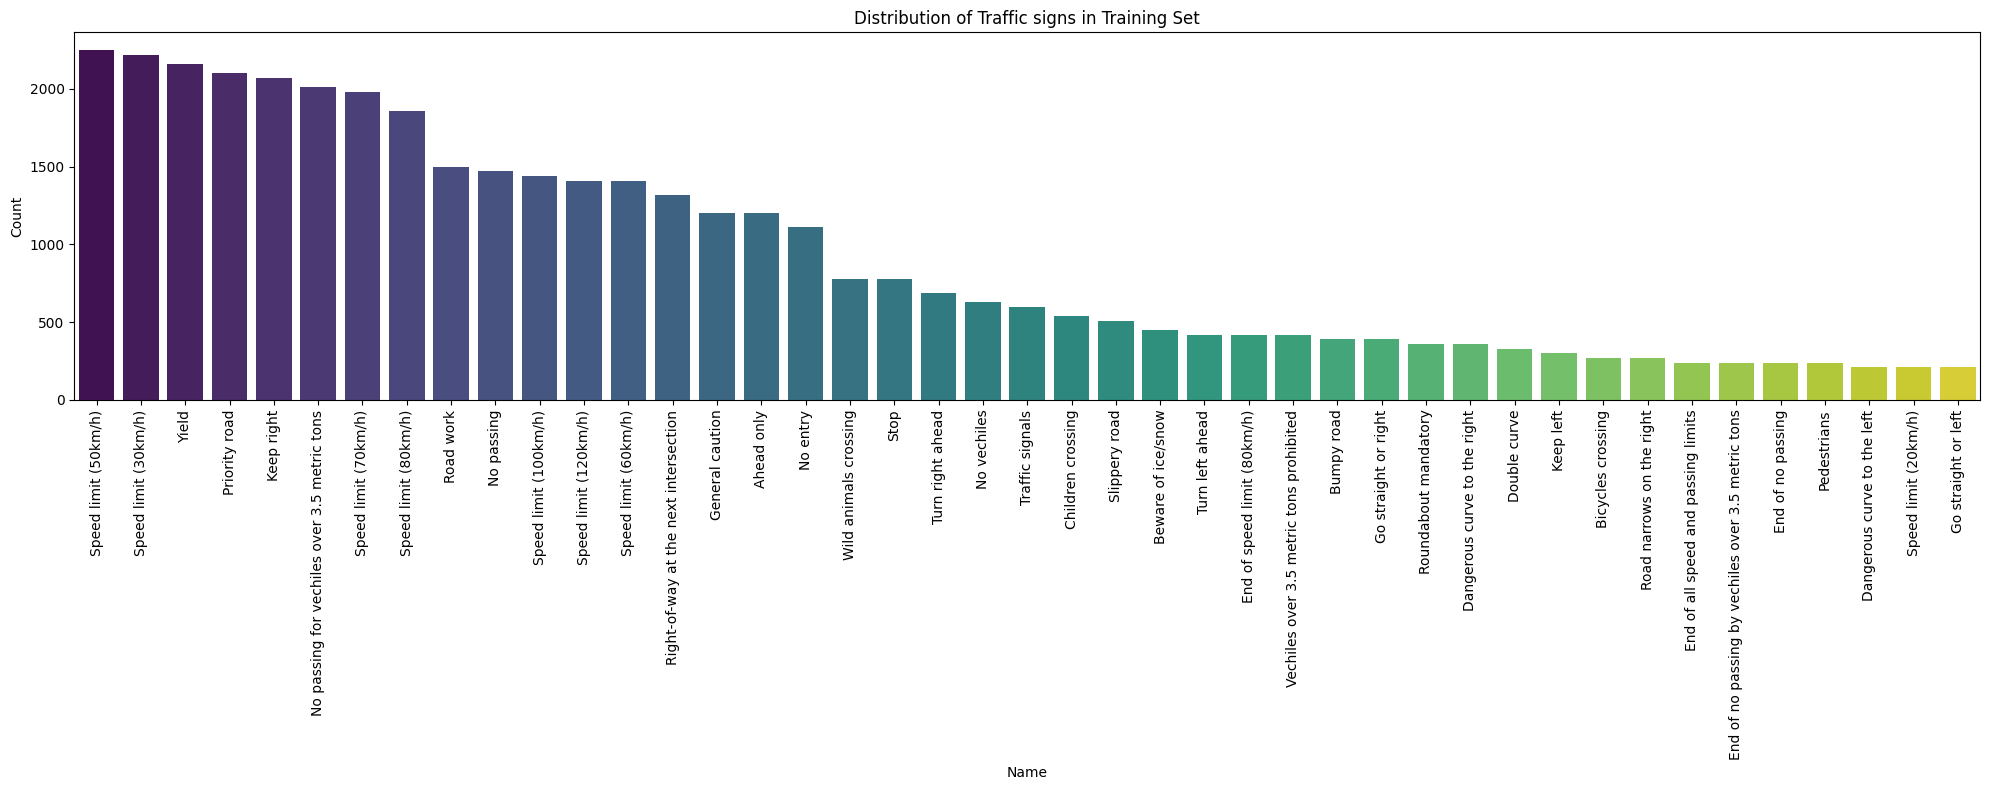

2025-11-28 03:48:59,769 [INFO]: Creating datasets from directory...


Found 39209 files belonging to 43 classes.
Using 31368 files for training.


2025-11-28 03:49:04,103 [INFO]: Captured 43 classes.


Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


2025-11-28 03:49:05,097 [INFO]: Loading test data from /content/GTSRB_local/Test.csv...
2025-11-28 03:49:05,995 [INFO]: Found 12630 valid test images.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3152 - loss: 2.7253
Epoch 1: val_accuracy improved from -inf to 0.72044, saving model to GTSRB_TRAFFIC_SIGN_best.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 63s 51ms/step - accuracy: 0.3154 - loss: 2.7246 - val_accuracy: 0.7204 - val_loss: 0.9506 - learning_rate: 1.0000e-04
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6447 - loss: 1.1597
Epoch 2: val_accuracy improved from 0.72044 to 0.80015, saving model to GTSRB_TRAFFIC_SIGN_best.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.6448 - loss: 1.1596 - val_accuracy: 0.8002 - val_loss: 0.6702 - learning_rate: 1.0000e-04
Epoch 3/30
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7272 - loss: 0.8788
Epoch 3: val_accuracy improved from 0.80015 to 0.84300, saving model to GTSRB_TRAFFIC_SIGN_best.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7273 - loss: 0.8788 - val_accuracy: 

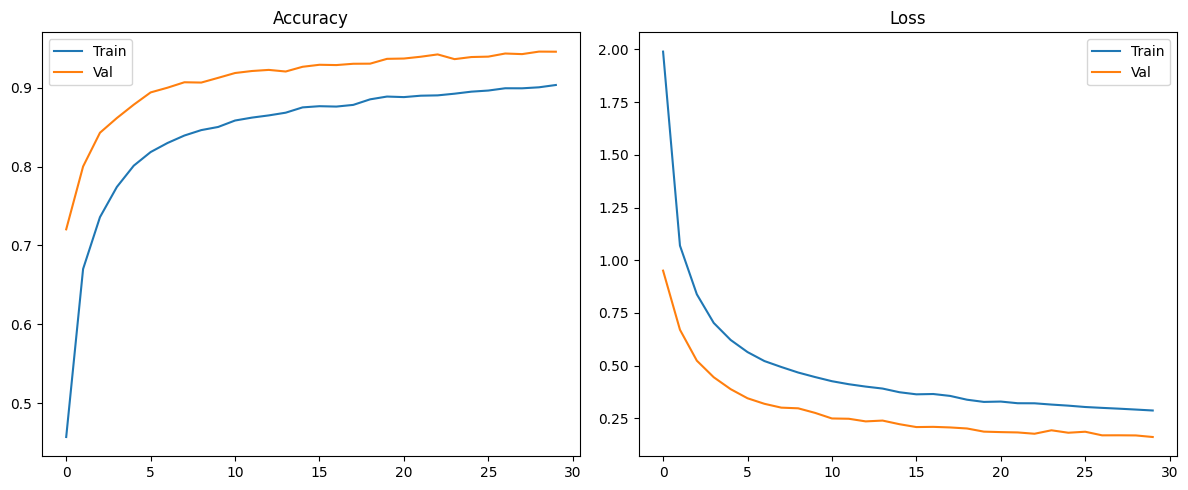

2025-11-28 04:16:16,225 [INFO]: Fine-tuning...


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9108 - loss: 0.2587
Epoch 1: val_accuracy improved from -inf to 0.96110, saving model to GTSRB_TRAFFIC_SIGN_finetuned.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 106s 93ms/step - accuracy: 0.9109 - loss: 0.2587 - val_accuracy: 0.9611 - val_loss: 0.1140
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9496 - loss: 0.1534
Epoch 2: val_accuracy improved from 0.96110 to 0.97258, saving model to GTSRB_TRAFFIC_SIGN_finetuned.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 94s 93ms/step - accuracy: 0.9496 - loss: 0.1534 - val_accuracy: 0.9726 - val_loss: 0.0853
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9644 - loss: 0.1074
Epoch 3: val_accuracy improved from 0.97258 to 0.98266, saving model to GTSRB_TRAFFIC_SIGN_finetuned.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 93s 92ms/step - accuracy: 0.9644 - loss: 0.1074 - val_accuracy: 0.9827 - val_loss: 0.0547
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy

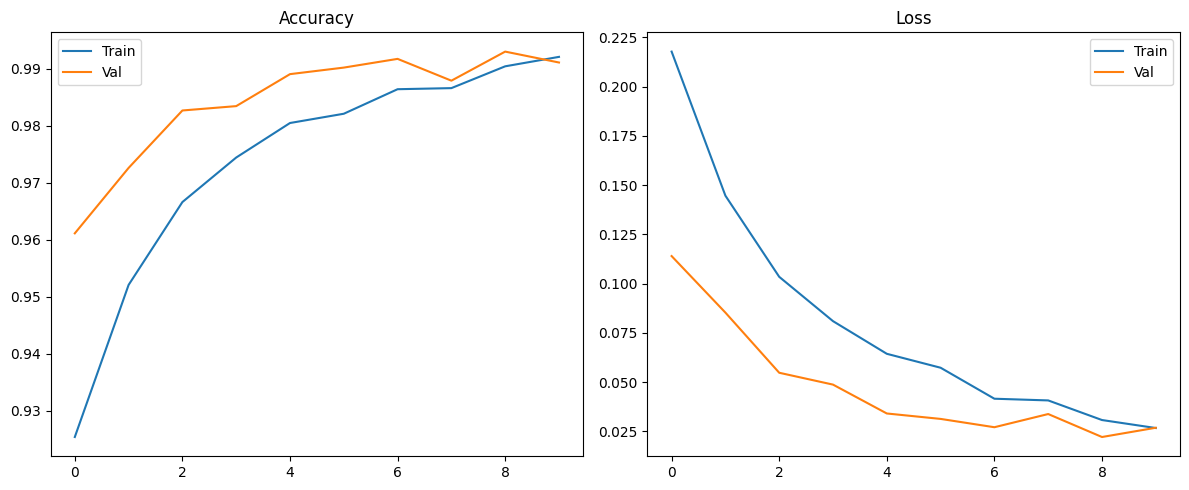

2025-11-28 04:33:03,229 [INFO]: Generating confusion matrix...



--- Validation Results ---


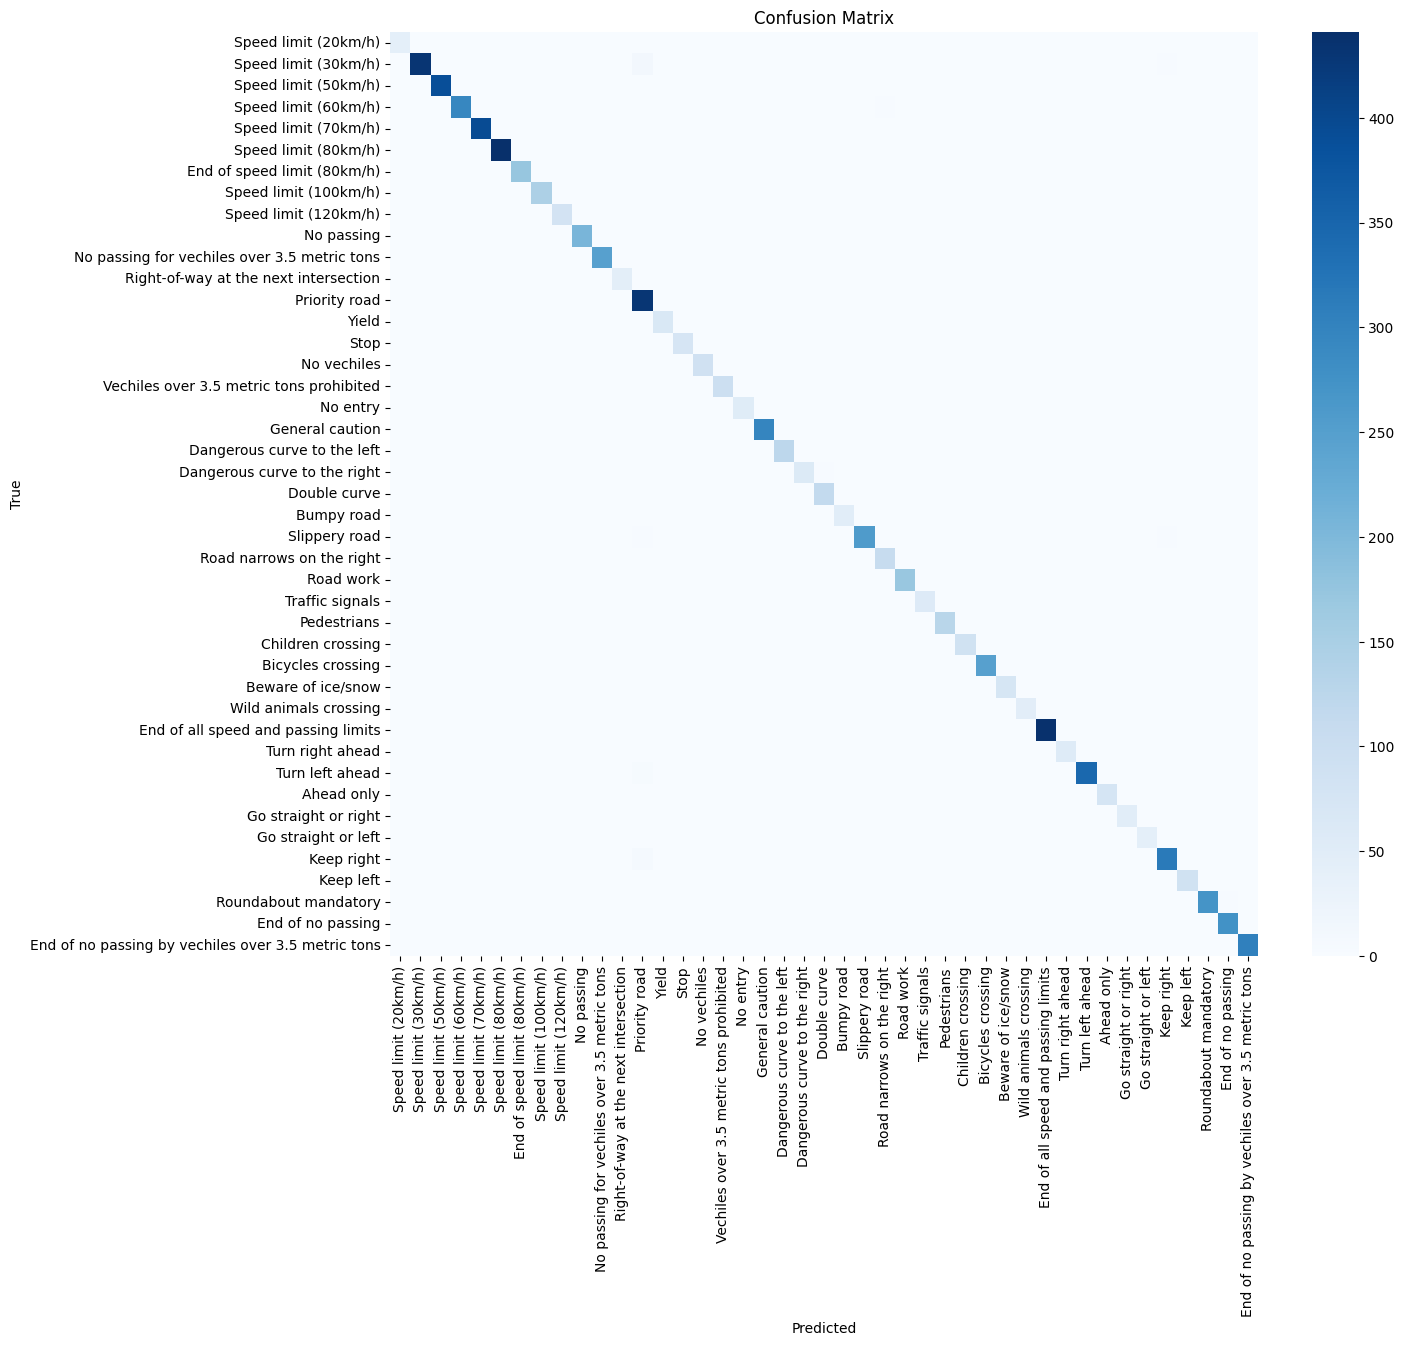

Classification Report:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.98      0.99        44
                              Speed limit (30km/h)       1.00      0.96      0.98       448
                              Speed limit (50km/h)       1.00      1.00      1.00       390
                              Speed limit (60km/h)       1.00      0.99      0.99       297
                              Speed limit (70km/h)       1.00      1.00      1.00       396
                              Speed limit (80km/h)       1.00      1.00      1.00       441
                       End of speed limit (80km/h)       1.00      1.00      1.00       173
                             Speed limit (100km/h)       1.00      1.00      1.00       146
                             Speed limit (120km/h)       1.00      1.00      1.00        82
                                        No passing      

2025-11-28 04:33:49,456 [INFO]: Test Accuracy: 0.9352
2025-11-28 04:33:49,456 [INFO]: Generating confusion matrix...


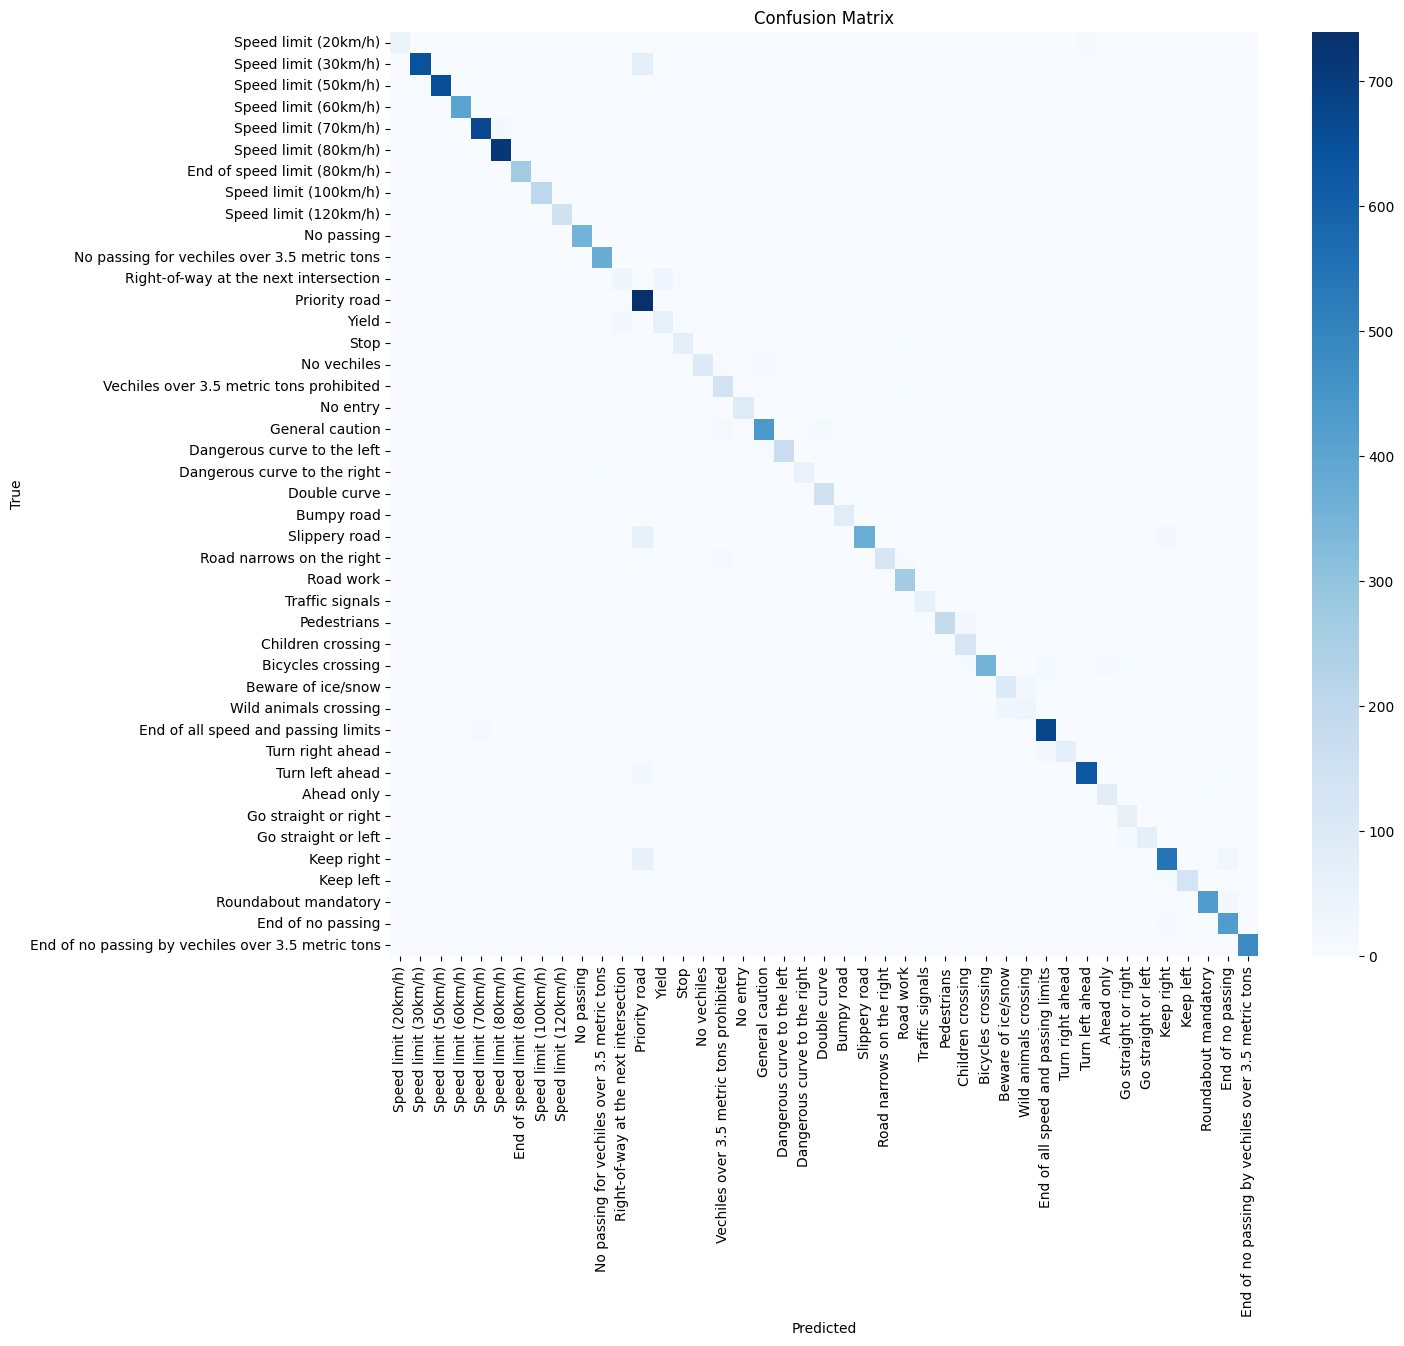

Classification Report:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.94      0.77      0.84        60
                              Speed limit (30km/h)       0.99      0.89      0.94       720
                              Speed limit (50km/h)       0.99      0.99      0.99       660
                              Speed limit (60km/h)       0.97      0.97      0.97       420
                              Speed limit (70km/h)       0.98      0.97      0.97       690
                              Speed limit (80km/h)       0.97      0.99      0.98       720
                       End of speed limit (80km/h)       0.98      1.00      0.99       270
                             Speed limit (100km/h)       1.00      0.99      0.99       210
                             Speed limit (120km/h)       0.98      1.00      0.99       150
                                        No passing      

In [ ]:
def main():
    config = Config()
    data_manager = GTSRBDataManager(config)
    data_manager.setup_data()

    try:
        label_map = data_manager.load_signnames_csv()

        # EDA
        eda = EDAExplorer(config, label_map)
        eda.plot_class_distribution()

        train_ds, val_ds = data_manager.get_datasets()
        test_ds = data_manager.get_test_dataset()

    except FileNotFoundError as e:
        logger.error(str(e))
        return

    # Build & Train
    ts_model = TrafficSignModel(config)
    ts_model.build()

    history = ts_model.train(train_ds, val_ds)
    Visualizer.plot_history(history)

    # Fine Tune
    history_ft = ts_model.fine_tune(train_ds, val_ds, history)
    Visualizer.plot_history(history_ft)

    # Evaluation
    print("\n--- Validation Results ---")
    Visualizer.plot_confusion_matrix(ts_model.model, val_ds, label_map)

    if test_ds:
        print("\n--- Test Set Results ---")
        ts_model.evaluate(test_ds)
        Visualizer.plot_confusion_matrix(ts_model.model, test_ds, label_map)

    # Save Final Model to Drive
    drive_save_path = Path("/content/drive/MyDrive/GTSRB/Traffic Project/my_final_model.keras")
    ts_model.model.save(drive_save_path)
    print(f"Model saved to {drive_save_path}")

if __name__ == "__main__":
    main()

## 7. Inference Engine
A reusable class to generate predictions from file paths or raw image data.

In [ ]:
class TrafficSignPredictor:
    """Wrapper to use the trained model for inference on files or raw data."""

    def __init__(self, model_path, config, data_manager):
        self.cfg = config
        self.label_map = data_manager.load_signnames_csv()
        self.dm = data_manager

        print(f"Loading model from {model_path}...")
        self.model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")

    def preprocess(self, img_rgb):
        """Standard preprocessing pipeline."""
        img_resized = cv2.resize(img_rgb, self.cfg.IMG_SIZE)
        img_batch = tf.expand_dims(img_resized, axis=0)
        img_batch = tf.cast(img_batch, tf.float32)
        return tf.keras.applications.mobilenet_v2.preprocess_input(img_batch)

    def predict(self, img_input, is_filepath=True):
        """
        Main prediction method.
        Args:
            img_input: Either a filepath string OR a numpy array (RGB)
            is_filepath: True if passing a path, False if passing raw image
        """
        if is_filepath:
            img = cv2.imread(img_input)
            if img is None: return "Error: Image not found", 0.0
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_rgb = img_input

        # Preprocess
        img_tensor = self.preprocess(img_rgb)

        # Predict
        preds = self.model.predict(img_tensor, verbose=0)

        # Decoding label
        idx = np.argmax(preds)
        conf = float(np.max(preds))

        # Map Index
        class_id_str = self.dm.class_names[idx]
        true_id = int(class_id_str)

        label = self.label_map.get(true_id, f"Class {true_id}")
        return label, conf

## 8. Interactive Demo (Gradio)
Launching a web app to test the model with own images.

In [ ]:
# Dependencies
config = Config()
dm = GTSRBDataManager(config)
if not config.TRAIN_DIR.exists(): dm.setup_data()
_ = dm.get_datasets()

# Predictory
model_path = "/content/drive/MyDrive/GTSRB/Traffic Project/my_final_model.keras"
predictor = TrafficSignPredictor(model_path, config, dm)

# Interface wrapper
def classify_image(input_img):
    if input_img is None: return None
    label, conf = predictor.predict(input_img, is_filepath=False)

    return {label: conf}

# Launching
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(label="Upload Traffic Sign"),
    outputs=gr.Label(num_top_classes=1),
    title="🚦 Traffic Sign Recognizer",
    description="Upload an image of a German Traffic Sign to identify it."
)

interface.launch(debug=True, share=True)